# Redes Neurais com PyTorch

As redes de aprendizagem profunda tendem a ser enormes, com dezenas ou centenas de camadas, é daí que vem o termo “profundo”. Você pode construir uma dessas redes profundas usando apenas matrizes de peso, como fizemos no notebook anterior, mas em geral é muito complicado e difícil de implementar. PyTorch possui um ótimo módulo `nn` que fornece uma ótima maneira de construir grandes redes neurais com eficiência.

In [77]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt

Agora vamos construir uma rede maior que pode resolver um problema (anteriormente) difícil: identificar texto em uma imagem. Aqui usaremos o conjunto de dados MNIST, que consiste em dígitos manuscritos em escala de cinza. Cada imagem tem 28x28 pixels, você pode ver um exemplo abaixo

<img src='assets/mnist.png'>

Nosso objetivo é construir uma rede neural que possa pegar uma dessas imagens e prever o dígito na imagem.

Primeiro, precisamos obter nosso conjunto de dados. Isto é fornecido através do pacote `torchvision`. O código abaixo fará o download do conjunto de dados MNIST e, em seguida, criará conjuntos de dados de treinamento e teste para nós. Não se preocupe muito com os detalhes aqui, você aprenderá mais sobre isso mais tarde.

In [34]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Temos os dados de treinamento carregados em `trainloader` e transformamos isso em um iterador com `iter(trainloader)`. Posteriormente, usaremos isso para percorrer o conjunto de dados para treinamento, como

```python
for image, label in trainloader:
     ## faça coisas com imagens e rótulos
```

Você notará que criei o `trainloader` com um tamanho de lote de 64 e `shuffle=True`. O tamanho do lote é o número de imagens que obtemos em uma iteração do carregador de dados e passamos por nossa rede, geralmente chamado de *lote*. E `shuffle=True` diz para embaralhar o conjunto de dados toda vez que começarmos a passar pelo carregador de dados novamente. Mas aqui estou apenas pegando o primeiro lote para que possamos verificar os dados. Podemos ver abaixo que `images` é apenas um tensor com tamanho `(64, 1, 28, 28)`. Portanto, 64 imagens por lote, 1 canal de cores e imagens 28x28.

In [35]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Esta é a aparência de uma das imagens.

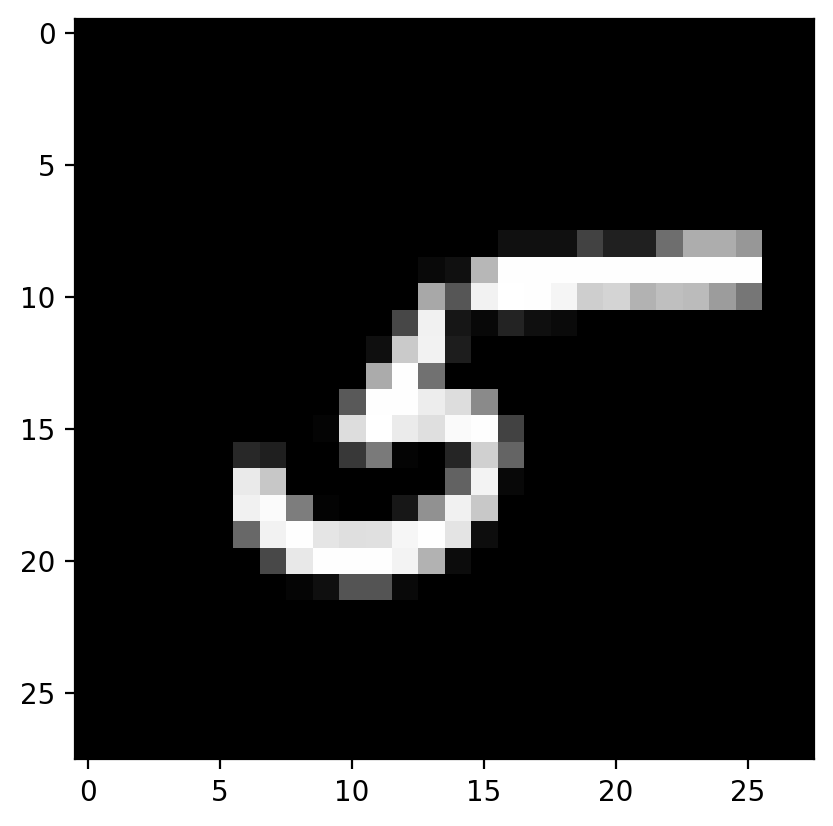

In [36]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

Primeiro, vamos tentar construir uma rede simples para este conjunto de dados usando matrizes de pesos e multiplicações de matrizes. A seguir, veremos como fazer isso usando o módulo `nn` do PyTorch, que fornece um método muito mais conveniente e poderoso para definir arquiteturas de rede.

As redes que você viu até agora são chamadas de redes *totalmente conectadas* ou *densas*. Cada unidade em uma camada está conectada a cada unidade na próxima camada. Em redes totalmente conectadas, a entrada para cada camada deve ser um vetor unidimensional (que pode ser empilhado em um tensor 2D como um lote de múltiplos exemplos). No entanto, nossas imagens são tensores 2D 28x28, então precisamos convertê-las em vetores 1D. Pensando em tamanhos, precisamos converter o lote de imagens com formato `(64, 1, 28, 28)` para um formato `(64, 784)`, 784 é 28 vezes 28. Isso normalmente é chamado de * achatamento*, achatamos as imagens 2D em vetores 1D.

Anteriormente você construía uma rede com uma unidade de saída. Aqui precisamos de 10 unidades de saída, uma para cada dígito. Queremos que nossa rede preveja o dígito mostrado em uma imagem, então o que faremos é calcular as probabilidades de a imagem pertencer a qualquer dígito ou classe. Isso acaba sendo uma distribuição de probabilidade discreta sobre as classes (dígitos) que nos indica a classe mais provável para a imagem. Isso significa que precisamos de 10 unidades de saída para as 10 classes (dígitos). Veremos a seguir como converter a saída da rede em uma distribuição de probabilidade.

> **Exercício:** Achate o lote de imagens `images`. Em seguida, construa uma rede multicamadas com 784 unidades de entrada, 256 unidades ocultas e 10 unidades de saída usando tensores aleatórios para pesos e tendências. Por enquanto, use uma ativação sigmóide para a camada oculta. Deixe a camada de saída sem ativação, adicionaremos a seguir uma que nos dê uma distribuição de probabilidade.

In [39]:
## Your solution   

## Activation function
def activation(x):
    """ Sigmoid activation function 
        Arguments
        ---------
        x: torch.Tensor
    """
    return 1/(1+torch.exp(-x))

### Neural network
def multi_Layer_NW(inputUnits, hiddenUnits, outputUnits):
    torch.manual_seed(7) # Set the random seed so things are predictable

    # Define the size of each layer in our network
    n_input = inputUnits     # Number of input units, must match number of input features
    n_hidden = hiddenUnits   # Number of hidden units 
    n_output = outputUnits   # Number of output units

    # Weights for inputs to hidden layer
    W1 = torch.randn(n_input, n_hidden)
    # Weights for hidden layer to output layer
    W2 = torch.randn(n_hidden, n_output)

    # and bias terms for hidden and output layers
    B1 = torch.randn((1, n_hidden))
    B2 = torch.randn((1, n_output))

    return W1,W2,B1,B2

def calc_output(features,W1,W2,B1,B2):
    h = activation(torch.matmul(features,W1).add_(B1))
    output = activation(torch.matmul(h,W2).add_(B2))
    return output

# Features are flattened batch input
features = torch.flatten(images,start_dim=1)
W1,W2,B1,B2 = multi_Layer_NW(features.shape[1],256,10)

out = calc_output(features,W1,W2,B1,B2) # output of your network, should have shape (64,10)

Agora temos 10 saídas para nossa rede. Queremos passar uma imagem para nossa rede e obter uma distribuição de probabilidade sobre as classes que nos diga a(s) provável(s) classe(s) à(s) qual(is) a imagem pertence. Algo parecido com isto:
<img src='assets/image_distribution.png' largura=500px>

Aqui vemos que a probabilidade para cada classe é aproximadamente a mesma. Isso representa uma rede não treinada, ainda não viu nenhum dado, então apenas retorna uma distribuição uniforme com probabilidades iguais para cada classe.

Para calcular essa distribuição de probabilidade, geralmente usamos a [**softmax** função](https://en.wikipedia.org/wiki/Softmax_function). Matematicamente isso parece

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

O que isso faz é comprimir cada entrada $x_i$ entre 0 e 1 e normalizar os valores para fornecer uma distribuição de probabilidade adequada, onde as probabilidades somam um.

> **Exercício:** Implemente uma função `softmax` que execute o cálculo softmax e retorne distribuições de probabilidade para cada exemplo no lote. Observe que você precisará prestar atenção às formas ao fazer isso. Se você tiver um tensor `a` com forma `(64, 10)` e um tensor `b` com forma `(64,)`, fazer `a/b` causará um erro porque o PyTorch tentará fazer o divisão entre as colunas (chamada de transmissão), mas você obterá uma incompatibilidade de tamanho. A maneira de pensar sobre isso é para cada um dos 64 exemplos, você só quer dividir por um valor, a soma no denominador. Então você precisa que `b` tenha uma forma de `(64, 1)`. Desta forma, o PyTorch dividirá os 10 valores em cada linha de `a` por um valor em cada linha de `b`. Preste atenção em como você calcula a soma também. Você precisará definir a palavra-chave `dim` em `torch.sum`. Definir `dim=0` leva a soma entre as linhas enquanto `dim=1` leva a soma entre as colunas.

In [40]:
def softmax(x):
    # Calcula a exponencial de cada elemento em x
    exp_x = torch.exp(x)
    
    # Calcula a soma ao longo da dimensão das classes (dim=1) para obter o denominador da softmax
    sum_exp_x = torch.sum(exp_x, dim=1, keepdim=True)
    
    # Divide cada elemento pela soma correspondente ao longo da dimensão das classes
    probabilities = exp_x / sum_exp_x
    
    return probabilities

# Aqui, out deve ser a saída da rede no exercício anterior com formato (64,10)
probabilidades = softmax(out)

# Tem o formato correto? Deve ser (64, 10)
print(probabilidades.shape)
# Soma para 1?
print(probabilidades.sum(dim=1))


torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


## Construindo redes com PyTorch

PyTorch fornece um módulo `nn` que torna a construção de redes muito mais simples. Aqui vou mostrar como construir o mesmo acima com 784 entradas, 256 unidades ocultas, 10 unidades de saída e uma saída softmax.

In [42]:
from torch import nn

In [43]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

Vamos repassar isso aos poucos.

```píton
classe Rede (nn.Module):
```

Aqui estamos herdando de `nn.Module`. Combinado com `super().__init__()` isso cria uma classe que rastreia a arquitetura e fornece muitos métodos e atributos úteis. É obrigatório herdar de `nn.Module` ao criar uma classe para sua rede. O nome da classe em si pode ser qualquer coisa.

```python
self.hidden = nn.Linear(784, 256)
```

Esta linha cria um módulo para uma transformação linear, $x\mathbf{W} + b$, com 784 entradas e 256 saídas e o atribui a `self.hidden`. O módulo cria automaticamente os tensores de peso e polarização que usaremos no método `forward`. Você pode acessar os tensores de peso e polarização assim que a rede (`net`) for criada com `net.hidden.weight` e `net.hidden.bias`.

```python
self.output = nn.Linear(256, 10)
```

Da mesma forma, isto cria outra transformação linear com 256 entradas e 10 saídas.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```

Aqui defini operações para ativação sigmóide e saída softmax. Definir `dim=1` em `nn.Softmax(dim=1)` calcula softmax nas colunas.

```python
def forward(self, x):
```

As redes PyTorch criadas com `nn.Module` devem ter um método `forward` definido. Ele recebe um tensor `x` e o passa pelas operações que você definiu no método `__init__`.

```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```

Aqui, o tensor de entrada `x` é passado por cada operação e reatribuído a `x`. Podemos ver que o tensor de entrada passa pela camada oculta, depois por uma função sigmóide, depois pela camada de saída e, finalmente, pela função softmax. Não importa como você nomeia as variáveis aqui, desde que as entradas e saídas das operações correspondam à arquitetura de rede que você deseja construir. A ordem em que você define as coisas no método `__init__` não importa, mas você precisará sequenciar as operações corretamente no método `forward`.

Agora podemos criar um objeto `Network`.

In [44]:
# Create the network and look at its text representation
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

Você pode definir a rede de forma mais concisa e clara usando o módulo `torch.nn.funcional`. Esta é a maneira mais comum de ver redes definidas, já que muitas operações são funções simples elemento a elemento. Normalmente importamos este módulo como `F`, `import torch.nn.funcional as F`.

In [45]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.sigmoid(self.hidden(x))
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=1)
        
        return x

### Funções de ativação

Até agora vimos apenas a função de ativação sigmóide, mas em geral qualquer função pode ser usada como função de ativação. O único requisito é que para que uma rede se aproxime de uma função não linear, as funções de ativação sejam não lineares. Aqui estão mais alguns exemplos de funções de ativação comuns: Tanh (tangente hiperbólica) e ReLU (unidade linear retificada).

<img src="assets/activation.png" largura=700px>

Na prática, a função ReLU é usada quase exclusivamente como função de ativação para camadas ocultas.

### Sua vez de construir uma rede

<img src="assets/mlp_mnist.png" largura=600px>

> **Exercício:** Crie uma rede com 784 unidades de entrada, uma camada oculta com 128 unidades e uma ativação ReLU, depois uma camada oculta com 64 unidades e uma ativação ReLU e, finalmente, uma camada de saída com uma ativação softmax conforme mostrado acima . Você pode usar uma ativação ReLU com o módulo `nn.ReLU` ou a função `F.relu`.

É uma boa prática nomear suas camadas pelo tipo de rede, por exemplo, 'fc' para representar uma camada totalmente conectada. Ao codificar sua solução, use `fc1`, `fc2` e `fc3` como nomes de camada.

In [70]:
## Your solution here
class Network2(nn.Module):
    def __init__(self):
        super().__init__()
        # Camada de entrada para a primeira camada oculta com transformação linear
        self.fc1 = nn.Linear(784, 128)
        ## Segunda camada oculta, de 128 para 64 unidades
        self.fc2 = nn.Linear(128, 64)
        # Camada de saída, de 64 para 10 unidades
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        # Primeira camada oculta com ativação ReLU
        x = F.relu(self.fc1(x))
        # Segunda camada oculta com ativação ReLU
        x = F.relu(self.fc2(x))
        # Output layer with softmax activation
        x = F.softmax(self.fc3(x), dim=1)
        
        return x

### Inicializando pesos e biases

Os pesos e outros itens são inicializados automaticamente para você, mas é possível personalizar como eles são inicializados. Os pesos e vieses são tensores anexados à camada que você definiu, você pode obtê-los com `model.fc1.weight` por exemplo.

In [71]:
model = Network2()
model

Network2(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [72]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[ 0.0164,  0.0219, -0.0102,  ..., -0.0201, -0.0034,  0.0079],
        [ 0.0338, -0.0111, -0.0109,  ...,  0.0318, -0.0061, -0.0122],
        [-0.0121,  0.0242,  0.0219,  ..., -0.0135, -0.0310, -0.0265],
        ...,
        [-0.0089,  0.0253,  0.0007,  ..., -0.0297, -0.0015, -0.0148],
        [-0.0015,  0.0280, -0.0258,  ...,  0.0222,  0.0169, -0.0207],
        [-0.0029, -0.0296, -0.0105,  ..., -0.0353, -0.0053, -0.0271]],
       requires_grad=True)
Parameter containing:
tensor([-2.2625e-02, -2.1760e-02, -2.3485e-02, -5.9706e-03,  3.0550e-02,
         2.8102e-02, -2.0875e-02,  2.4581e-02,  2.7445e-02, -6.4085e-03,
        -3.5931e-03, -1.3154e-02, -8.3722e-03, -3.5473e-02, -2.1347e-02,
        -6.0426e-03, -9.2314e-03,  5.8297e-03,  3.0558e-03, -8.2860e-03,
        -1.4496e-02, -8.3113e-03,  5.9933e-03, -1.6310e-03, -1.1819e-02,
         2.3809e-02,  3.4297e-02, -2.6947e-02,  3.2758e-02, -3.4678e-02,
         1.5105e-02,  1.0064e-03, -4.2143e-04,  8.3707e-0

Para inicialização personalizada, queremos modificar esses tensores no local. Na verdade, essas são *Variáveis* de autogradação, então precisamos recuperar os tensores reais com `model.fc1.weight.data`. Assim que tivermos os tensores, podemos preenchê-los com zeros (para vieses) ou valores normais aleatórios.

In [73]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [74]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 0.0126,  0.0086,  0.0008,  ...,  0.0178,  0.0160,  0.0025],
        [-0.0035,  0.0002, -0.0047,  ..., -0.0056, -0.0140,  0.0024],
        [-0.0112,  0.0177, -0.0016,  ..., -0.0037,  0.0134, -0.0082],
        ...,
        [ 0.0047,  0.0009, -0.0103,  ...,  0.0057,  0.0123, -0.0089],
        [ 0.0138, -0.0047, -0.0211,  ...,  0.0169,  0.0259,  0.0112],
        [ 0.0005,  0.0102,  0.0110,  ...,  0.0013, -0.0128, -0.0058]])

### Forward pass

Agora que temos uma rede, vamos ver o que acontece quando passamos uma imagem.

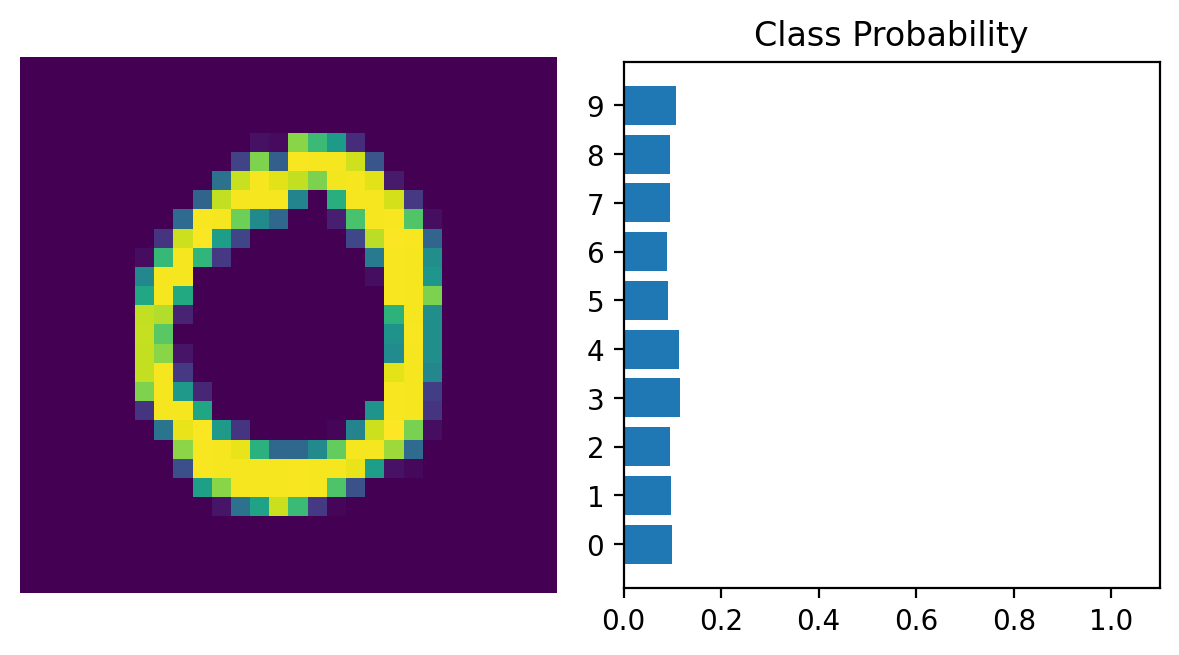

In [78]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
helper.view_classify(img.view(1, 28, 28), ps)

Como você pode ver acima, nossa rede basicamente não tem ideia do que seja esse dígito. É porque ainda não treinamos, todos os pesos são aleatórios!

### Usando `nn.Sequential`

PyTorch fornece uma maneira conveniente de construir redes como esta, onde um tensor é passado sequencialmente por meio de operações, `nn.Sequential` ([documentação](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential )). Usando isso para construir a rede equivalente:

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


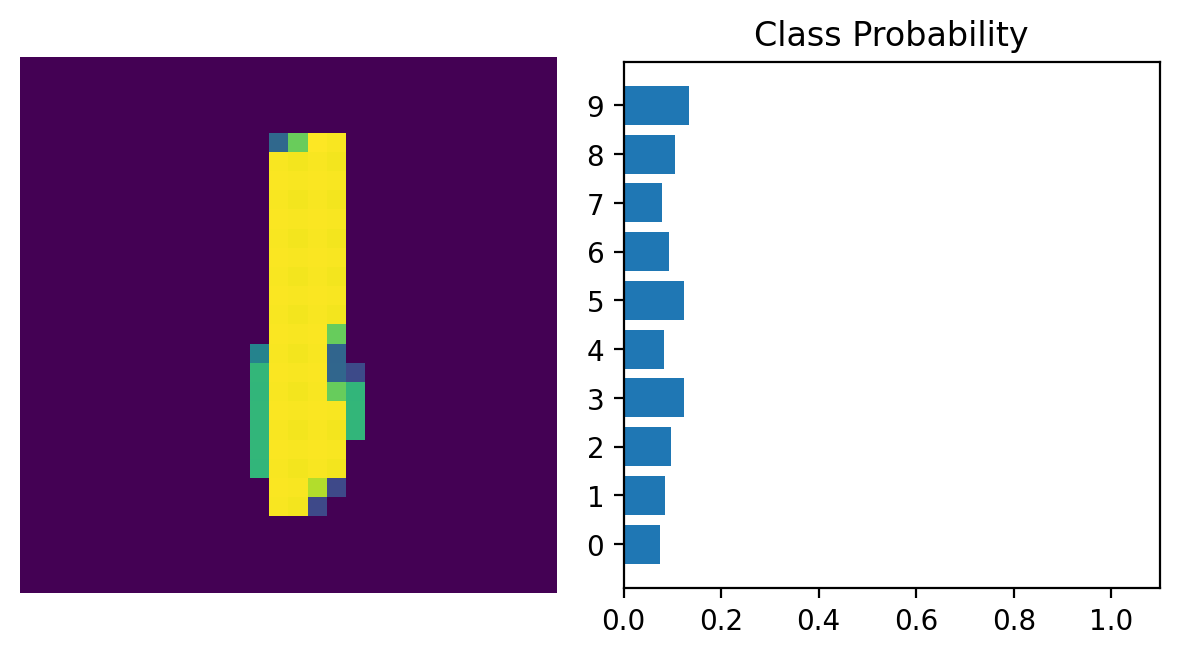

In [79]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)

Aqui nosso modelo é o mesmo de antes: 784 unidades de entrada, uma camada oculta com 128 unidades, ativação ReLU, camada oculta de 64 unidades, outra ReLU, depois a camada de saída com 10 unidades e a saída softmax.

As operações estão disponíveis passando o índice apropriado. Por exemplo, se você deseja obter a primeira operação linear e observar os pesos, você usaria `model[0]`.

In [80]:
print(model[0])
model[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[-0.0177, -0.0286, -0.0102,  ..., -0.0284, -0.0289,  0.0189],
        [-0.0083, -0.0183, -0.0098,  ..., -0.0074,  0.0226,  0.0281],
        [-0.0198,  0.0333,  0.0057,  ...,  0.0206,  0.0167,  0.0031],
        ...,
        [-0.0209, -0.0278, -0.0323,  ...,  0.0315, -0.0191, -0.0205],
        [ 0.0011, -0.0014, -0.0081,  ...,  0.0119, -0.0287, -0.0036],
        [-0.0309, -0.0139, -0.0279,  ..., -0.0292, -0.0174,  0.0249]],
       requires_grad=True)

Você também pode passar um `OrderedDict` para nomear as camadas e operações individuais, em vez de usar números inteiros incrementais. Observe que as chaves do dicionário devem ser exclusivas, portanto _cada operação deve ter um nome diferente_.

In [82]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

Agora você pode acessar as camadas por número inteiro ou pelo nome

In [83]:
print(model[0])
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)


No próximo caderno, veremos como podemos treinar uma rede neural para prever com precisão os números que aparecem nas imagens MNIST.